# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [12]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [13]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
         logits = self.mlp_stack(x)
         return logits

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [14]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    
    X_train, y_train, X_test, y_test = split_dataset(df, 'filename', 0.30, 1)
    X_train = X_train.drop(columns=['label'])
    X_test = X_test.drop(columns=['label'])
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [15]:
class CustomDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):

    train_data = CustomDataset(X_train_scaled,y_train)
    test_data = CustomDataset(X_test_scaled,y_test)
    
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)
    
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [16]:
# YOUR CODE HERE
model = MLP(77,128,2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [17]:
# YOUR CODE HERE
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= num_batches
    train_correct /=size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_correct /= size
    
    return test_loss, test_correct

class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
early_stopper = EarlyStopper(patience=3, min_delta=0)
epochs = 100

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 53.53%, Train_loss: 0.689125, Test_accuracy: 55.25%, Test_loss: 0.684195
Epoch 2: Train_accuracy: 57.39%, Train_loss: 0.677221, Test_accuracy: 58.37%, Test_loss: 0.669224
Epoch 3: Train_accuracy: 60.08%, Train_loss: 0.664017, Test_accuracy: 59.01%, Test_loss: 0.669963
Epoch 4: Train_accuracy: 62.10%, Train_loss: 0.653311, Test_accuracy: 60.64%, Test_loss: 0.657464
Epoch 5: Train_accuracy: 63.27%, Train_loss: 0.645041, Test_accuracy: 60.48%, Test_loss: 0.656279
Epoch 6: Train_accuracy: 64.94%, Train_loss: 0.630563, Test_accuracy: 61.66%, Test_loss: 0.647726
Epoch 7: Train_accuracy: 66.24%, Train_loss: 0.623052, Test_accuracy: 62.08%, Test_loss: 0.657153
Epoch 8: Train_accuracy: 67.13%, Train_loss: 0.616102, Test_accuracy: 64.54%, Test_loss: 0.643068
Epoch 9: Train_accuracy: 68.57%, Train_loss: 0.603951, Test_accuracy: 64.04%, Test_loss: 0.642026
Epoch 10: Train_accuracy: 69.98%, Train_loss: 0.596726, Test_accuracy: 64.59%, Test_loss: 0.638322
Epoch 11: Train_acc

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


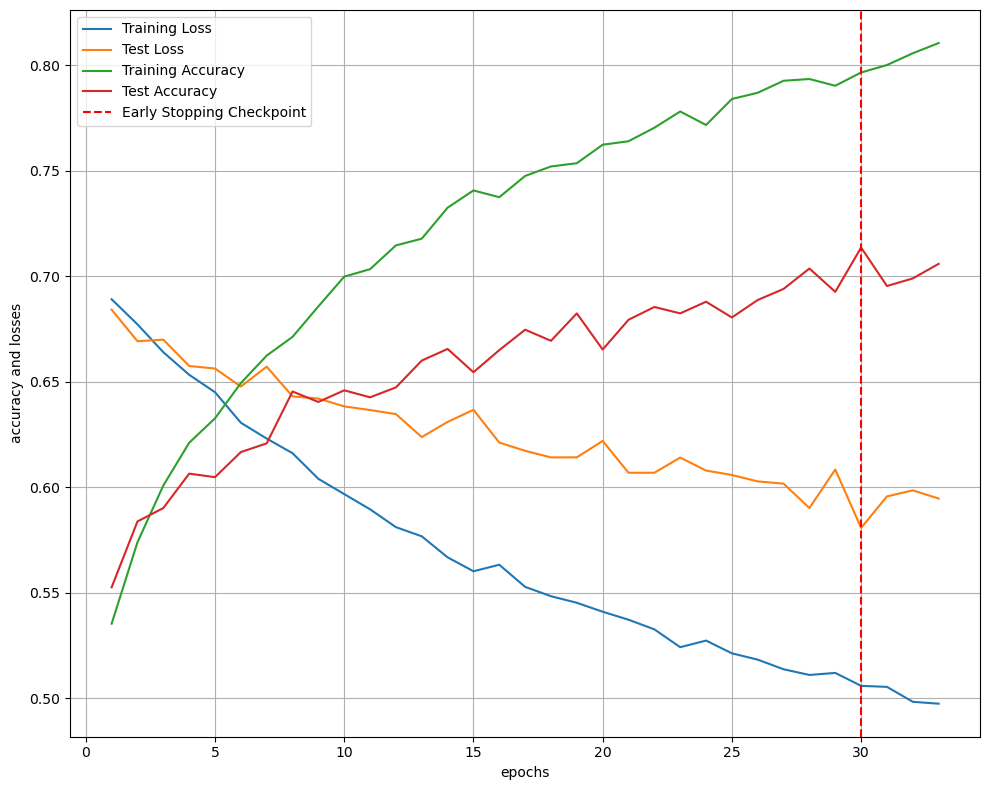

In [18]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Test Loss')
plt.plot(range(1,len(tr_correct)+1),tr_correct,label='Training Accuracy')
plt.plot(range(1,len(te_correct)+1),te_correct,label='Test Accuracy')

# find position of lowest validation loss
minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy and losses')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

2. Comment on line plots.

In [19]:
# YOUR CODE HERE
answer = "Early stopping checkpoint happens at epoch 30."